# Regression task using the Individual Household Electric Power Consumption dataset (LSTM Based RNN)

Import necessary libraries

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import urllib.request
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Metric
import tensorflow.keras.backend as K
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
# Define the URL and filename
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'
filename = 'household_power_consumption.zip'


Download the dataset

In [ ]:
if not os.path.exists(filename):
    urllib.request.urlretrieve(url, filename)

# Extract the dataset
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall()


In [ ]:
# Load the dataset with better parse_dates approach
data = pd.read_csv('household_power_consumption.txt', sep=';',
                   parse_dates={'Datetime': ['Date', 'Time']},
                   infer_datetime_format=True,
                   na_values='?',
                   low_memory=False)

<ipython-input-5-e6199b05b448>:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  data = pd.read_csv('household_power_consumption.txt', sep=';',
<ipython-input-5-e6199b05b448>:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv('household_power_consumption.txt', sep=';',
<ipython-input-5-e6199b05b448>:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv('household_power_consumption.txt', sep=';',


In [ ]:
# Set 'Datetime' as the index
data.set_index('Datetime', inplace=True)

Data Exploration

In [ ]:
print("Dataset shape:", data.shape)
print("\nDataset information:")
print(data.info())

Dataset shape: (2075259, 7)

Dataset information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB
None


In [ ]:
print("\nSummary statistics:")
print(data.describe())


Summary statistics:
       Global_active_power  Global_reactive_power       Voltage  \
count         2.049280e+06           2.049280e+06  2.049280e+06   
mean          1.091615e+00           1.237145e-01  2.408399e+02   
std           1.057294e+00           1.127220e-01  3.239987e+00   
min           7.600000e-02           0.000000e+00  2.232000e+02   
25%           3.080000e-01           4.800000e-02  2.389900e+02   
50%           6.020000e-01           1.000000e-01  2.410100e+02   
75%           1.528000e+00           1.940000e-01  2.428900e+02   
max           1.112200e+01           1.390000e+00  2.541500e+02   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
count      2.049280e+06    2.049280e+06    2.049280e+06    2.049280e+06  
mean       4.627759e+00    1.121923e+00    1.298520e+00    6.458447e+00  
std        4.444396e+00    6.153031e+00    5.822026e+00    8.437154e+00  
min        2.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00  
25%  

In [ ]:
# Check for missing values in each column and sum them up
missing_values = data.isnull().sum()
print("\nMissing values per column:")
print(missing_values)


Missing values per column:
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


In [ ]:
# Calculate percentage of missing values
missing_percentage = (missing_values / len(data)) * 100
print("\nPercentage of missing values:")
print(missing_percentage)


Percentage of missing values:
Global_active_power      1.251844
Global_reactive_power    1.251844
Voltage                  1.251844
Global_intensity         1.251844
Sub_metering_1           1.251844
Sub_metering_2           1.251844
Sub_metering_3           1.251844
dtype: float64


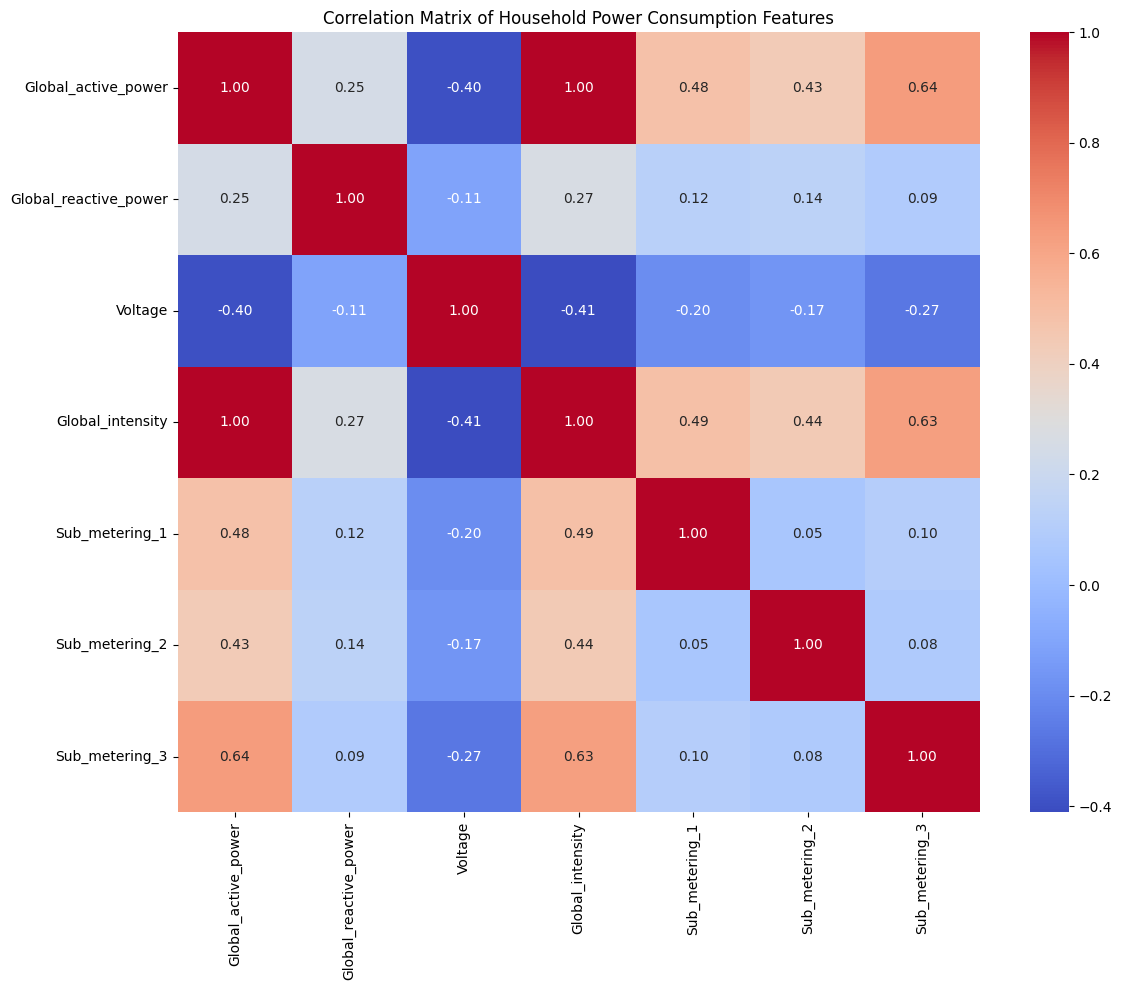

In [ ]:
# Plotting correlation matrix for all features
plt.figure(figsize=(12, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Household Power Consumption Features')
plt.tight_layout()
plt.show()

Data Preprocessing

In [ ]:
# 1. Handle missing values with interpolation instead of just forward fill
data_cleaned = data.interpolate(method='time')
data_cleaned = data_cleaned.fillna(method='bfill').fillna(method='ffill')


<ipython-input-14-a3bd460e2fec>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_cleaned = data_cleaned.fillna(method='bfill').fillna(method='ffill')


In [ ]:
# Check if any missing values remain
missing_after_cleaning = data_cleaned.isnull().sum()
print("\nMissing values after cleaning:")
print(missing_after_cleaning)


Missing values after cleaning:
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


In [ ]:
# 2. Feature engineering - Add time-based features
data_cleaned['hour'] = data_cleaned.index.hour
data_cleaned['day_of_week'] = data_cleaned.index.dayofweek
data_cleaned['month'] = data_cleaned.index.month
data_cleaned['is_weekend'] = (data_cleaned.index.dayofweek >= 5).astype(int)


In [ ]:
# 3. Resample to hourly data with richer aggregation
hourly_data = data_cleaned.resample('H').agg({
    'Global_active_power': 'mean',
    'Global_reactive_power': 'mean',
    'Voltage': 'mean',
    'Global_intensity': 'mean',
    'Sub_metering_1': 'mean',
    'Sub_metering_2': 'mean',
    'Sub_metering_3': 'mean',
    'hour': 'first',
    'day_of_week': 'first',
    'month': 'first',
    'is_weekend': 'first'
})

<ipython-input-17-596a5a735e33>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_data = data_cleaned.resample('H').agg({


In [ ]:
# 4. Feature selection - Create additional engineered features
hourly_data['power_factor'] = hourly_data['Global_active_power'] / (
        np.sqrt(hourly_data['Global_active_power']**2 + hourly_data['Global_reactive_power']**2) + 1e-10)

hourly_data['other_consumption'] = hourly_data['Global_active_power'] * 1000 / 60 - (
        hourly_data['Sub_metering_1'] + hourly_data['Sub_metering_2'] + hourly_data['Sub_metering_3'])


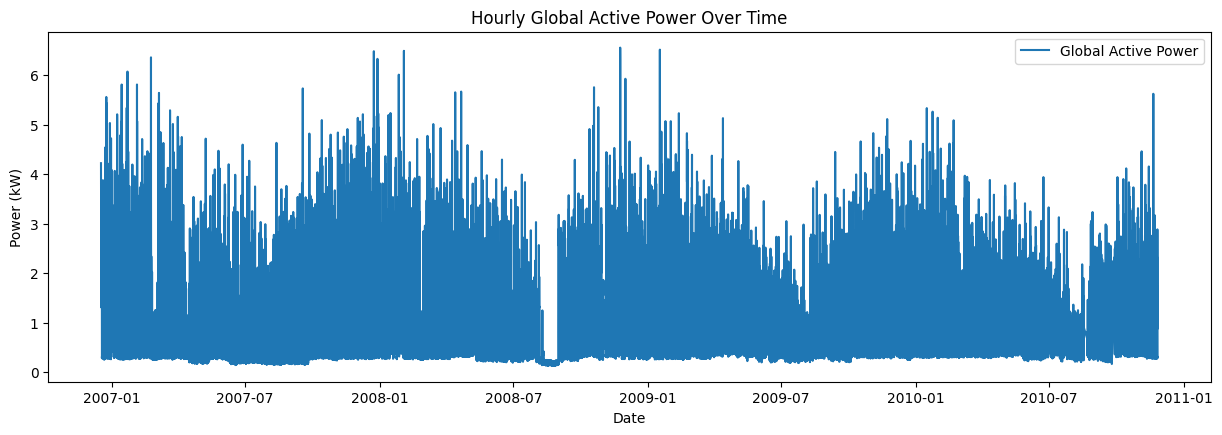

In [ ]:
# 5. Visualization of target variable (Global_active_power) patterns
plt.figure(figsize=(15, 10))

# Time series plot
plt.subplot(2, 1, 1)
plt.plot(hourly_data['Global_active_power'], label='Global Active Power')
plt.title('Hourly Global Active Power Over Time')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.legend()

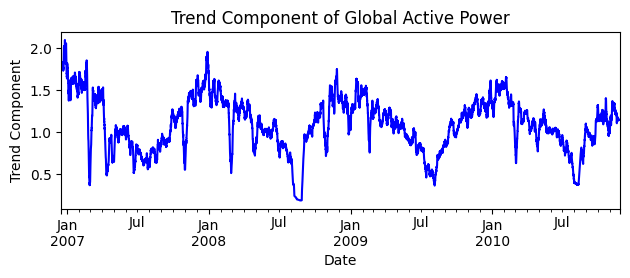

In [ ]:
# Decomposition to visualize trend, seasonality
decomposition = seasonal_decompose(hourly_data['Global_active_power'].dropna(), model='additive', period=24*7)
plt.subplot(2, 1, 2)
decomposition.trend.plot(label='Trend', color='blue')
plt.title('Trend Component of Global Active Power')
plt.xlabel('Date')
plt.ylabel('Trend Component')
plt.tight_layout()
plt.show()

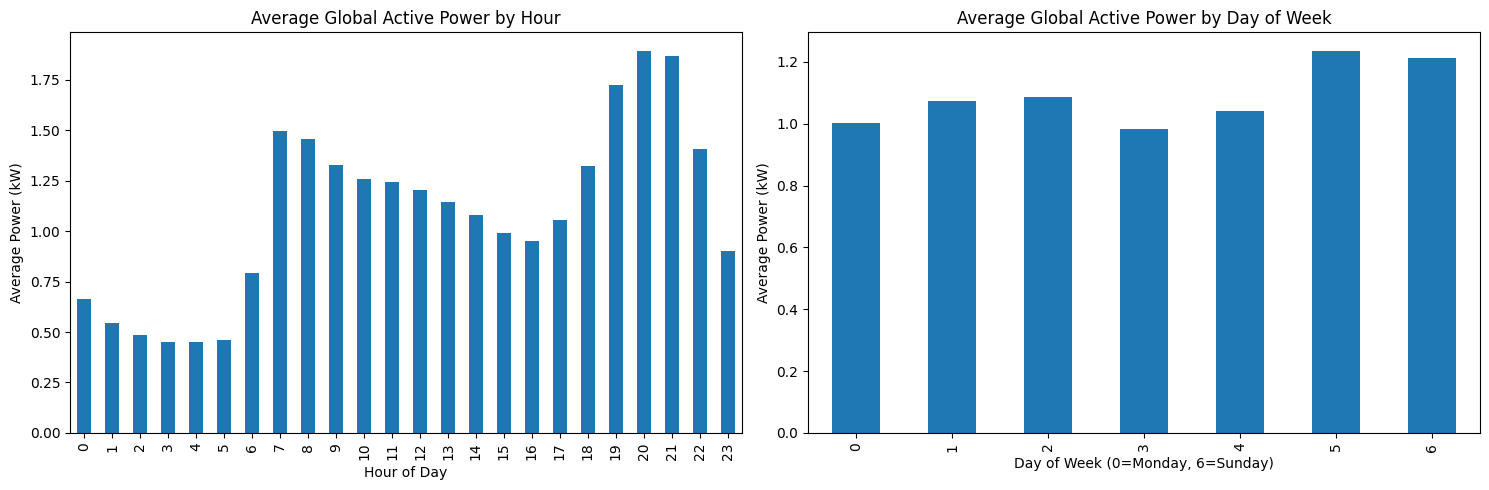

In [ ]:
# Seasonal patterns by hour and day of week
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
hourly_data.groupby('hour')['Global_active_power'].mean().plot(kind='bar')
plt.title('Average Global Active Power by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Power (kW)')

plt.subplot(1, 2, 2)
hourly_data.groupby('day_of_week')['Global_active_power'].mean().plot(kind='bar')
plt.title('Average Global Active Power by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Power (kW)')
plt.tight_layout()
plt.show()

Prepare features for model input

In [ ]:
# Select features for the model
selected_features = ['Global_active_power', 'Global_reactive_power', 'Voltage',
                     'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
                     'Sub_metering_3', 'hour', 'day_of_week', 'month', 'is_weekend',
                     'power_factor', 'other_consumption']

# Get input data
model_data = hourly_data[selected_features].copy()

In [ ]:
# Normalize the data
scaler_dict = {}
normalized_data = model_data.copy()

for column in model_data.columns:
    scaler = MinMaxScaler()
    normalized_data[column] = scaler.fit_transform(model_data[column].values.reshape(-1, 1))
    scaler_dict[column] = scaler

In [ ]:
# Save the target variable scaler for later use
target_scaler = scaler_dict['Global_active_power']


In [ ]:
# Define an improved function to create multivariate sequences
def create_sequences(data, seq_length, target_col='Global_active_power'):
    """Create sequences with multiple features and a single target."""
    X, y = [], []
    for i in range(len(data) - seq_length):
        # All features for the sequence
        X.append(data.iloc[i:i+seq_length].values)
        # Only the target variable for prediction
        y.append(data.iloc[i+seq_length][target_col])
    return np.array(X), np.array(y)

In [ ]:
# Define sequence length - using 48 hours (2 days) or try 24 (1 day)
seq_length = 24

In [ ]:
# Create sequences
X, y = create_sequences(normalized_data, seq_length)

# Split into training, validation, and testing datasets (70% train, 15% validation, 15% test)
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (24195, 24, 13)
Validation set shape: (5184, 24, 13)
Testing set shape: (5186, 24, 13)


In [ ]:
# Define R² metric
class R2Score(Metric):
    def __init__(self, name='r2_score', **kwargs):
        super(R2Score, self).__init__(name=name, **kwargs)
        self.sse = self.add_weight(name='sse', initializer='zeros')
        self.sst = self.add_weight(name='sst', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = K.flatten(y_true)
        y_pred = K.flatten(y_pred)
        self.sse.assign_add(K.sum(K.square(y_true - y_pred)))
        self.sst.assign_add(K.sum(K.square(y_true - K.mean(y_true))))

    def result(self):
        return 1 - (self.sse / (self.sst + K.epsilon()))

    def reset_states(self):
        self.sse.assign(0.)
        self.sst.assign(0.)

 # Build a bidirectional LSTM model with regularization.

In [ ]:
# Build an improved LSTM model
def build_advanced_model(input_shape):

    model = Sequential()

    # First Bidirectional LSTM layer with more units
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Second Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(64)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Dense layers with batch normalization
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())

    # Output layer
    model.add(Dense(1))

    # Compile with a lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='mse',
        metrics=[R2Score()]
    )

    return model

In [ ]:
# Create model
model = build_advanced_model((X_train.shape[1], X_train.shape[2]))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 24, 256)        │       145,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 24, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 316,161 (1.21 MB)

 Trainable params: 315,297 (1.20 MB)

 Non-trainable params: 864 (3.38 KB)

In [ ]:
# Define improved callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.0001,
        verbose=1
    ),
    ModelCheckpoint(
        'best_power_consumption_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

In [ ]:
# Train the model with more epochs
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0327 - r2_score: -0.6027
Epoch 1: val_loss improved from 0.01728 to 0.01705, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0327 - r2_score: -0.6026 - val_loss: 0.0170 - val_r2_score: 0.0280 - learning_rate: 1.0000e-04
Epoch 2/150
376/379 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0292 - r2_score: -0.4410
Epoch 2: val_loss did not improve from 0.01705
379/379 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0292 - r2_score: -0.4408 - val_loss: 0.0174 - val_r2_score: 0.0078 - learning_rate: 1.0000e-04
Epoch 3/150
378/379 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0279 - r2_score: -0.3586
Epoch 3: val_loss improved from 0.01705 to 0.01654, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0279 - r2_score: -0.3584 - val_loss: 0.0165 - val_r2_score: 0.0568 - learning_rate: 1.0000e-04
Epoch 4/150
376/379 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0251 - r2_score: -0.2667
Epoch 4: val_loss improved from 0.01654 to 0.01567, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0251 - r2_score: -0.2665 - val_loss: 0.0157 - val_r2_score: 0.1063 - learning_rate: 1.0000e-04
Epoch 5/150
377/379 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0241 - r2_score: -0.1853
Epoch 5: val_loss improved from 0.01567 to 0.01526, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0241 - r2_score: -0.1852 - val_loss: 0.0153 - val_r2_score: 0.1297 - learning_rate: 1.0000e-04
Epoch 6/150
378/379 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0232 - r2_score: -0.1182
Epoch 6: val_loss improved from 0.01526 to 0.01361, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0232 - r2_score: -0.1181 - val_loss: 0.0136 - val_r2_score: 0.2241 - learning_rate: 1.0000e-04
Epoch 7/150
377/379 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0230 - r2_score: -0.1269
Epoch 7: val_loss did not improve from 0.01361
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0230 - r2_score: -0.1269 - val_loss: 0.0144 - val_r2_score: 0.1788 - learning_rate: 1.0000e-04
Epoch 8/150
378/379 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0223 - r2_score: -0.0902
Epoch 8: val_loss improved from 0.01361 to 0.01276, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0223 - r2_score: -0.0900 - val_loss: 0.0128 - val_r2_score: 0.2726 - learning_rate: 1.0000e-04
Epoch 9/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0210 - r2_score: -0.0346
Epoch 9: val_loss improved from 0.01276 to 0.01222, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0210 - r2_score: -0.0345 - val_loss: 0.0122 - val_r2_score: 0.3032 - learning_rate: 1.0000e-04
Epoch 10/150
377/379 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0202 - r2_score: 0.0254
Epoch 10: val_loss improved from 0.01222 to 0.01161, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0202 - r2_score: 0.0255 - val_loss: 0.0116 - val_r2_score: 0.3377 - learning_rate: 1.0000e-04
Epoch 11/150
378/379 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0193 - r2_score: 0.0617
Epoch 11: val_loss improved from 0.01161 to 0.01097, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0193 - r2_score: 0.0617 - val_loss: 0.0110 - val_r2_score: 0.3743 - learning_rate: 1.0000e-04
Epoch 12/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0181 - r2_score: 0.1187
Epoch 12: val_loss improved from 0.01097 to 0.01086, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0181 - r2_score: 0.1186 - val_loss: 0.0109 - val_r2_score: 0.3805 - learning_rate: 1.0000e-04
Epoch 13/150
377/379 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0180 - r2_score: 0.1257
Epoch 13: val_loss improved from 0.01086 to 0.01012, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0179 - r2_score: 0.1259 - val_loss: 0.0101 - val_r2_score: 0.4228 - learning_rate: 1.0000e-04
Epoch 14/150
378/379 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0167 - r2_score: 0.1734
Epoch 14: val_loss did not improve from 0.01012
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0167 - r2_score: 0.1735 - val_loss: 0.0101 - val_r2_score: 0.4224 - learning_rate: 1.0000e-04
Epoch 15/150
376/379 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0164 - r2_score: 0.1781
Epoch 15: val_loss did not improve from 0.01012
379/379 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0164 - r2_score: 0.1783 - val_loss: 0.0102 - val_r2_score: 0.4158 - learning_rate: 1.0000e-04
Epoch 16/150
377/379 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0167 - r2_score: 0.1908
Epoch 16: val_loss improved from 0.01012 to 0.00995, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0167 - r2_score: 0.1909 - val_loss: 0.0100 - val_r2_score: 0.4324 - learning_rate: 1.0000e-04
Epoch 17/150
376/379 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0159 - r2_score: 0.2253
Epoch 17: val_loss improved from 0.00995 to 0.00974, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0159 - r2_score: 0.2253 - val_loss: 0.0097 - val_r2_score: 0.4446 - learning_rate: 1.0000e-04
Epoch 18/150
376/379 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0158 - r2_score: 0.2273
Epoch 18: val_loss improved from 0.00974 to 0.00932, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0158 - r2_score: 0.2273 - val_loss: 0.0093 - val_r2_score: 0.4684 - learning_rate: 1.0000e-04
Epoch 19/150
378/379 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0152 - r2_score: 0.2557
Epoch 19: val_loss did not improve from 0.00932
379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0152 - r2_score: 0.2557 - val_loss: 0.0096 - val_r2_score: 0.4507 - learning_rate: 1.0000e-04
Epoch 20/150
376/379 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0152 - r2_score: 0.2644
Epoch 20: val_loss did not improve from 0.00932
379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0152 - r2_score: 0.2645 - val_loss: 0.0095 - val_r2_score: 0.4571 - learning_rate: 1.0000e-04
Epoch 21/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0146 - r2_score: 0.2825
Epoch 21: val_loss improved from 0.00932 to 0.00920, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0146 - r2_score: 0.2825 - val_loss: 0.0092 - val_r2_score: 0.4756 - learning_rate: 1.0000e-04
Epoch 22/150
376/379 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0138 - r2_score: 0.3254
Epoch 22: val_loss improved from 0.00920 to 0.00884, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0138 - r2_score: 0.3254 - val_loss: 0.0088 - val_r2_score: 0.4960 - learning_rate: 1.0000e-04
Epoch 23/150
378/379 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0137 - r2_score: 0.3323
Epoch 23: val_loss improved from 0.00884 to 0.00883, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0137 - r2_score: 0.3323 - val_loss: 0.0088 - val_r2_score: 0.4964 - learning_rate: 1.0000e-04
Epoch 24/150
378/379 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0135 - r2_score: 0.3388
Epoch 24: val_loss improved from 0.00883 to 0.00862, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0135 - r2_score: 0.3389 - val_loss: 0.0086 - val_r2_score: 0.5084 - learning_rate: 1.0000e-04
Epoch 25/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0127 - r2_score: 0.3786
Epoch 25: val_loss improved from 0.00862 to 0.00842, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0127 - r2_score: 0.3786 - val_loss: 0.0084 - val_r2_score: 0.5196 - learning_rate: 1.0000e-04
Epoch 26/150
376/379 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0133 - r2_score: 0.3541
Epoch 26: val_loss did not improve from 0.00842
379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0133 - r2_score: 0.3542 - val_loss: 0.0085 - val_r2_score: 0.5171 - learning_rate: 1.0000e-04
Epoch 27/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0124 - r2_score: 0.3988
Epoch 27: val_loss improved from 0.00842 to 0.00829, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.0124 - r2_score: 0.3988 - val_loss: 0.0083 - val_r2_score: 0.5270 - learning_rate: 1.0000e-04
Epoch 28/150
378/379 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0121 - r2_score: 0.4126
Epoch 28: val_loss improved from 0.00829 to 0.00818, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0121 - r2_score: 0.4126 - val_loss: 0.0082 - val_r2_score: 0.5337 - learning_rate: 1.0000e-04
Epoch 29/150
376/379 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0120 - r2_score: 0.4132
Epoch 29: val_loss improved from 0.00818 to 0.00807, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0120 - r2_score: 0.4131 - val_loss: 0.0081 - val_r2_score: 0.5398 - learning_rate: 1.0000e-04
Epoch 30/150
377/379 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0117 - r2_score: 0.4179
Epoch 30: val_loss improved from 0.00807 to 0.00801, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0117 - r2_score: 0.4179 - val_loss: 0.0080 - val_r2_score: 0.5435 - learning_rate: 1.0000e-04
Epoch 31/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0114 - r2_score: 0.4303
Epoch 31: val_loss did not improve from 0.00801
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0114 - r2_score: 0.4303 - val_loss: 0.0081 - val_r2_score: 0.5389 - learning_rate: 1.0000e-04
Epoch 32/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0115 - r2_score: 0.4392
Epoch 32: val_loss improved from 0.00801 to 0.00789, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0115 - r2_score: 0.4393 - val_loss: 0.0079 - val_r2_score: 0.5498 - learning_rate: 1.0000e-04
Epoch 33/150
376/379 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0113 - r2_score: 0.4484
Epoch 33: val_loss improved from 0.00789 to 0.00781, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0113 - r2_score: 0.4485 - val_loss: 0.0078 - val_r2_score: 0.5547 - learning_rate: 1.0000e-04
Epoch 34/150
377/379 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0111 - r2_score: 0.4592
Epoch 34: val_loss did not improve from 0.00781
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0111 - r2_score: 0.4592 - val_loss: 0.0079 - val_r2_score: 0.5513 - learning_rate: 1.0000e-04
Epoch 35/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0109 - r2_score: 0.4596
Epoch 35: val_loss did not improve from 0.00781
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0109 - r2_score: 0.4596 - val_loss: 0.0079 - val_r2_score: 0.5492 - learning_rate: 1.0000e-04
Epoch 36/150
376/379 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0110 - r2_score: 0.4782
Epoch 36: val_loss did not improve from 0.00781
379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0110 - r2_score: 0.4782 - val_loss: 0.0079 - val_r2_score: 0.5523 - learning_rate: 1.0000e-04
Epo

379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0109 - r2_score: 0.4658 - val_loss: 0.0077 - val_r2_score: 0.5622 - learning_rate: 1.0000e-04
Epoch 39/150
376/379 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0103 - r2_score: 0.4856
Epoch 39: val_loss did not improve from 0.00768
379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0103 - r2_score: 0.4856 - val_loss: 0.0077 - val_r2_score: 0.5610 - learning_rate: 1.0000e-04
Epoch 40/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0102 - r2_score: 0.4904
Epoch 40: val_loss improved from 0.00768 to 0.00760, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0102 - r2_score: 0.4904 - val_loss: 0.0076 - val_r2_score: 0.5668 - learning_rate: 1.0000e-04
Epoch 41/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0100 - r2_score: 0.4971
Epoch 41: val_loss did not improve from 0.00760
379/379 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.0100 - r2_score: 0.4971 - val_loss: 0.0077 - val_r2_score: 0.5621 - learning_rate: 1.0000e-04
Epoch 42/150
377/379 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0102 - r2_score: 0.5022
Epoch 42: val_loss improved from 0.00760 to 0.00757, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0102 - r2_score: 0.5021 - val_loss: 0.0076 - val_r2_score: 0.5685 - learning_rate: 1.0000e-04
Epoch 43/150
378/379 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0103 - r2_score: 0.4977
Epoch 43: val_loss improved from 0.00757 to 0.00756, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0103 - r2_score: 0.4977 - val_loss: 0.0076 - val_r2_score: 0.5690 - learning_rate: 1.0000e-04
Epoch 44/150
377/379 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0099 - r2_score: 0.5094
Epoch 44: val_loss improved from 0.00756 to 0.00752, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0099 - r2_score: 0.5094 - val_loss: 0.0075 - val_r2_score: 0.5709 - learning_rate: 1.0000e-04
Epoch 45/150
376/379 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0097 - r2_score: 0.5257
Epoch 45: val_loss improved from 0.00752 to 0.00740, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0097 - r2_score: 0.5257 - val_loss: 0.0074 - val_r2_score: 0.5780 - learning_rate: 1.0000e-04
Epoch 46/150
378/379 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0097 - r2_score: 0.5253
Epoch 46: val_loss did not improve from 0.00740
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0097 - r2_score: 0.5253 - val_loss: 0.0076 - val_r2_score: 0.5649 - learning_rate: 1.0000e-04
Epoch 47/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0095 - r2_score: 0.5320
Epoch 47: val_loss improved from 0.00740 to 0.00737, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0095 - r2_score: 0.5320 - val_loss: 0.0074 - val_r2_score: 0.5800 - learning_rate: 1.0000e-04
Epoch 48/150
377/379 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0096 - r2_score: 0.5328
Epoch 48: val_loss improved from 0.00737 to 0.00727, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0096 - r2_score: 0.5328 - val_loss: 0.0073 - val_r2_score: 0.5853 - learning_rate: 1.0000e-04
Epoch 49/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0095 - r2_score: 0.5202
Epoch 49: val_loss did not improve from 0.00727
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0095 - r2_score: 0.5202 - val_loss: 0.0075 - val_r2_score: 0.5731 - learning_rate: 1.0000e-04
Epoch 50/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0096 - r2_score: 0.5295
Epoch 50: val_loss improved from 0.00727 to 0.00724, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0096 - r2_score: 0.5295 - val_loss: 0.0072 - val_r2_score: 0.5873 - learning_rate: 1.0000e-04
Epoch 51/150
377/379 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0096 - r2_score: 0.5263
Epoch 51: val_loss did not improve from 0.00724
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0096 - r2_score: 0.5264 - val_loss: 0.0073 - val_r2_score: 0.5856 - learning_rate: 1.0000e-04
Epoch 52/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0094 - r2_score: 0.5393
Epoch 52: val_loss did not improve from 0.00724
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0094 - r2_score: 0.5393 - val_loss: 0.0074 - val_r2_score: 0.5782 - learning_rate: 1.0000e-04
Epoch 53/150
378/379 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0094 - r2_score: 0.5379
Epoch 53: val_loss did not improve from 0.00724
379/379 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0094 - r2_score: 0.5379 - val_loss: 0.0073 - val_r2_score: 0.5855 - learning_rate: 1.0000e-04
Epoch

379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0091 - r2_score: 0.5532 - val_loss: 0.0072 - val_r2_score: 0.5904 - learning_rate: 1.0000e-04
Epoch 58/150
378/379 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0092 - r2_score: 0.5416
Epoch 58: val_loss improved from 0.00718 to 0.00714, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0092 - r2_score: 0.5417 - val_loss: 0.0071 - val_r2_score: 0.5929 - learning_rate: 1.0000e-04
Epoch 59/150
378/379 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0091 - r2_score: 0.5581
Epoch 59: val_loss did not improve from 0.00714
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0091 - r2_score: 0.5582 - val_loss: 0.0072 - val_r2_score: 0.5900 - learning_rate: 1.0000e-04
Epoch 60/150
377/379 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0089 - r2_score: 0.5687
Epoch 60: val_loss did not improve from 0.00714
379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0089 - r2_score: 0.5687 - val_loss: 0.0072 - val_r2_score: 0.5908 - learning_rate: 1.0000e-04
Epoch 61/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0088 - r2_score: 0.5659
Epoch 61: val_loss improved from 0.00714 to 0.00706, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0088 - r2_score: 0.5659 - val_loss: 0.0071 - val_r2_score: 0.5976 - learning_rate: 1.0000e-04
Epoch 62/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0090 - r2_score: 0.5639
Epoch 62: val_loss did not improve from 0.00706
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0090 - r2_score: 0.5639 - val_loss: 0.0073 - val_r2_score: 0.5859 - learning_rate: 1.0000e-04
Epoch 63/150
378/379 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0090 - r2_score: 0.5653
Epoch 63: val_loss did not improve from 0.00706
379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0090 - r2_score: 0.5653 - val_loss: 0.0071 - val_r2_score: 0.5928 - learning_rate: 1.0000e-04
Epoch 64/150
377/379 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0088 - r2_score: 0.5676
Epoch 64: val_loss improved from 0.00706 to 0.00695, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0088 - r2_score: 0.5677 - val_loss: 0.0070 - val_r2_score: 0.6034 - learning_rate: 1.0000e-04
Epoch 65/150
378/379 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0088 - r2_score: 0.5753
Epoch 65: val_loss did not improve from 0.00695
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0088 - r2_score: 0.5753 - val_loss: 0.0071 - val_r2_score: 0.5953 - learning_rate: 1.0000e-04
Epoch 66/150
377/379 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0090 - r2_score: 0.5614
Epoch 66: val_loss did not improve from 0.00695
379/379 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.0090 - r2_score: 0.5614 - val_loss: 0.0073 - val_r2_score: 0.5842 - learning_rate: 1.0000e-04
Epoch 67/150
378/379 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0086 - r2_score: 0.5802
Epoch 67: val_loss did not improve from 0.00695
379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0086 - r2_score: 0.5802 - val_loss: 0.0071 - val_r2_score: 0.5964 - learning_rate: 1.0000e-04
Ep

379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0088 - r2_score: 0.5821 - val_loss: 0.0069 - val_r2_score: 0.6074 - learning_rate: 1.0000e-04
Epoch 70/150
378/379 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0087 - r2_score: 0.5686
Epoch 70: val_loss did not improve from 0.00688
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0087 - r2_score: 0.5686 - val_loss: 0.0070 - val_r2_score: 0.6023 - learning_rate: 1.0000e-04
Epoch 71/150
376/379 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0084 - r2_score: 0.5825
Epoch 71: val_loss did not improve from 0.00688
379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0084 - r2_score: 0.5826 - val_loss: 0.0070 - val_r2_score: 0.6017 - learning_rate: 1.0000e-04
Epoch 72/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0085 - r2_score: 0.5828
Epoch 72: val_loss improved from 0.00688 to 0.00686, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0085 - r2_score: 0.5828 - val_loss: 0.0069 - val_r2_score: 0.6089 - learning_rate: 1.0000e-04
Epoch 73/150
377/379 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0085 - r2_score: 0.5835
Epoch 73: val_loss improved from 0.00686 to 0.00685, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0085 - r2_score: 0.5835 - val_loss: 0.0069 - val_r2_score: 0.6093 - learning_rate: 1.0000e-04
Epoch 74/150
376/379 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0083 - r2_score: 0.5902
Epoch 74: val_loss did not improve from 0.00685
379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0083 - r2_score: 0.5902 - val_loss: 0.0070 - val_r2_score: 0.6022 - learning_rate: 1.0000e-04
Epoch 75/150
377/379 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0083 - r2_score: 0.5895
Epoch 75: val_loss did not improve from 0.00685
379/379 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0083 - r2_score: 0.5895 - val_loss: 0.0070 - val_r2_score: 0.6002 - learning_rate: 1.0000e-04
Epoch 76/150
378/379 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0084 - r2_score: 0.5908
Epoch 76: val_loss improved from 0.00685 to 0.00673, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0084 - r2_score: 0.5908 - val_loss: 0.0067 - val_r2_score: 0.6162 - learning_rate: 1.0000e-04
Epoch 77/150
376/379 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0083 - r2_score: 0.5965
Epoch 77: val_loss did not improve from 0.00673
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0083 - r2_score: 0.5965 - val_loss: 0.0068 - val_r2_score: 0.6112 - learning_rate: 1.0000e-04
Epoch 78/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0084 - r2_score: 0.5948
Epoch 78: val_loss did not improve from 0.00673
379/379 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.0084 - r2_score: 0.5948 - val_loss: 0.0068 - val_r2_score: 0.6122 - learning_rate: 1.0000e-04
Epoch 79/150
378/379 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0085 - r2_score: 0.5915
Epoch 79: val_loss did not improve from 0.00673
379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0085 - r2_score: 0.5915 - val_loss: 0.0068 - val_r2_score: 0.6140 - learning_rate: 1.0000e-04
Epo

379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0080 - r2_score: 0.6048 - val_loss: 0.0066 - val_r2_score: 0.6213 - learning_rate: 1.0000e-04
Epoch 86/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0080 - r2_score: 0.6018
Epoch 86: val_loss did not improve from 0.00664
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0080 - r2_score: 0.6018 - val_loss: 0.0067 - val_r2_score: 0.6200 - learning_rate: 1.0000e-04
Epoch 87/150
377/379 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0082 - r2_score: 0.6034
Epoch 87: val_loss did not improve from 0.00664
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0082 - r2_score: 0.6033 - val_loss: 0.0067 - val_r2_score: 0.6155 - learning_rate: 1.0000e-04
Epoch 88/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0082 - r2_score: 0.5952
Epoch 88: val_loss did not improve from 0.00664
379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0082 - r2_score: 0.5952 - val_loss: 0.0067 - val_r2_score: 0.6205 - learning_rate: 1.0000e-04
Epoc

379/379 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0079 - r2_score: 0.6146 - val_loss: 0.0066 - val_r2_score: 0.6219 - learning_rate: 1.0000e-04
Epoch 90/150
378/379 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0080 - r2_score: 0.6032
Epoch 90: val_loss did not improve from 0.00663
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0080 - r2_score: 0.6032 - val_loss: 0.0067 - val_r2_score: 0.6194 - learning_rate: 1.0000e-04
Epoch 91/150
377/379 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0080 - r2_score: 0.6108
Epoch 91: val_loss did not improve from 0.00663
379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0080 - r2_score: 0.6107 - val_loss: 0.0066 - val_r2_score: 0.6215 - learning_rate: 1.0000e-04
Epoch 92/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0079 - r2_score: 0.6046
Epoch 92: val_loss did not improve from 0.00663
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0079 - r2_score: 0.6046 - val_loss: 0.0067 - val_r2_score: 0.6159 - learning_rate: 1.0000e-04
Epoc

379/379 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.0079 - r2_score: 0.6030 - val_loss: 0.0066 - val_r2_score: 0.6240 - learning_rate: 1.0000e-04
Epoch 96/150
376/379 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0080 - r2_score: 0.6107
Epoch 96: val_loss did not improve from 0.00659
379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0080 - r2_score: 0.6106 - val_loss: 0.0067 - val_r2_score: 0.6203 - learning_rate: 1.0000e-04
Epoch 97/150
377/379 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0078 - r2_score: 0.6150
Epoch 97: val_loss did not improve from 0.00659
379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0078 - r2_score: 0.6149 - val_loss: 0.0066 - val_r2_score: 0.6217 - learning_rate: 1.0000e-04
Epoch 98/150
377/379 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0079 - r2_score: 0.6090
Epoch 98: val_loss did not improve from 0.00659
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0079 - r2_score: 0.6091 - val_loss: 0.0066 - val_r2_score: 0.6209 - learning_rate: 1.0000e-04
Ep

379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0079 - r2_score: 0.6217 - val_loss: 0.0065 - val_r2_score: 0.6271 - learning_rate: 1.0000e-04
Epoch 105/150
377/379 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0077 - r2_score: 0.6218
Epoch 105: val_loss improved from 0.00654 to 0.00653, saving model to best_power_consumption_model.h5


379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0077 - r2_score: 0.6218 - val_loss: 0.0065 - val_r2_score: 0.6278 - learning_rate: 1.0000e-04
Epoch 106/150
378/379 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0079 - r2_score: 0.6182
Epoch 106: val_loss did not improve from 0.00653
379/379 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0079 - r2_score: 0.6182 - val_loss: 0.0066 - val_r2_score: 0.6245 - learning_rate: 1.0000e-04
Epoch 107/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0075 - r2_score: 0.6283
Epoch 107: val_loss did not improve from 0.00653
379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0075 - r2_score: 0.6283 - val_loss: 0.0065 - val_r2_score: 0.6278 - learning_rate: 1.0000e-04
Epoch 108/150
378/379 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0076 - r2_score: 0.6252
Epoch 108: val_loss did not improve from 0.00653
379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0076 - r2_score: 0.6252 - val_loss: 0.0065 - val_r2_score: 0.6275 - learning_rate: 1.0000e

379/379 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0077 - r2_score: 0.6191 - val_loss: 0.0065 - val_r2_score: 0.6299 - learning_rate: 1.0000e-04
Epoch 113/150
376/379 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0077 - r2_score: 0.6322
Epoch 113: val_loss did not improve from 0.00649
379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0077 - r2_score: 0.6321 - val_loss: 0.0065 - val_r2_score: 0.6296 - learning_rate: 1.0000e-04
Epoch 114/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0077 - r2_score: 0.6246
Epoch 114: val_loss did not improve from 0.00649
379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0077 - r2_score: 0.6247 - val_loss: 0.0065 - val_r2_score: 0.6273 - learning_rate: 1.0000e-04
Epoch 115/150
378/379 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0076 - r2_score: 0.6280
Epoch 115: val_loss did not improve from 0.00649
379/379 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.0076 - r2_score: 0.6280 - val_loss: 0.0066 - val_r2_score: 0.6254 - learning_rate: 1.0000

379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0074 - r2_score: 0.6308 - val_loss: 0.0065 - val_r2_score: 0.6304 - learning_rate: 1.0000e-04
Epoch 119/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0075 - r2_score: 0.6295
Epoch 119: val_loss did not improve from 0.00648
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0075 - r2_score: 0.6295 - val_loss: 0.0066 - val_r2_score: 0.6245 - learning_rate: 1.0000e-04
Epoch 120/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0073 - r2_score: 0.6375
Epoch 120: val_loss did not improve from 0.00648
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0073 - r2_score: 0.6375 - val_loss: 0.0067 - val_r2_score: 0.6183 - learning_rate: 1.0000e-04
Epoch 121/150
378/379 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0078 - r2_score: 0.6137
Epoch 121: val_loss did not improve from 0.00648
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0078 - r2_score: 0.6137 - val_loss: 0.0065 - val_r2_score: 0.6293 - learning_rate: 1.0000e-0

379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0076 - r2_score: 0.6335 - val_loss: 0.0065 - val_r2_score: 0.6321 - learning_rate: 1.0000e-04
Epoch 123/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0075 - r2_score: 0.6337
Epoch 123: val_loss did not improve from 0.00645
379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0075 - r2_score: 0.6337 - val_loss: 0.0066 - val_r2_score: 0.6249 - learning_rate: 1.0000e-04
Epoch 124/150
376/379 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0077 - r2_score: 0.6255
Epoch 124: val_loss did not improve from 0.00645
379/379 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.0077 - r2_score: 0.6256 - val_loss: 0.0065 - val_r2_score: 0.6298 - learning_rate: 1.0000e-04
Epoch 125/150
377/379 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0076 - r2_score: 0.6335
Epoch 125: val_loss did not improve from 0.00645
379/379 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0076 - r2_score: 0.6334 - val_loss: 0.0065 - val_r2_score: 0.6311 - learning_rate: 1.0000e-

379/379 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0076 - r2_score: 0.6361 - val_loss: 0.0064 - val_r2_score: 0.6349 - learning_rate: 1.0000e-04
Epoch 131/150
378/379 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0078 - r2_score: 0.6252
Epoch 131: val_loss did not improve from 0.00640
379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0078 - r2_score: 0.6252 - val_loss: 0.0065 - val_r2_score: 0.6317 - learning_rate: 1.0000e-04
Epoch 132/150
376/379 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0074 - r2_score: 0.6383
Epoch 132: val_loss did not improve from 0.00640
379/379 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0074 - r2_score: 0.6383 - val_loss: 0.0065 - val_r2_score: 0.6308 - learning_rate: 1.0000e-04
Epoch 133/150
378/379 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0075 - r2_score: 0.6291
Epoch 133: val_loss did not improve from 0.00640
379/379 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0075 - r2_score: 0.6291 - val_loss: 0.0065 - val_r2_score: 0.6301 - learning_rate: 1.0000e-

In [ ]:
# Plot training history
plt.figure(figsize=(15, 5))

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

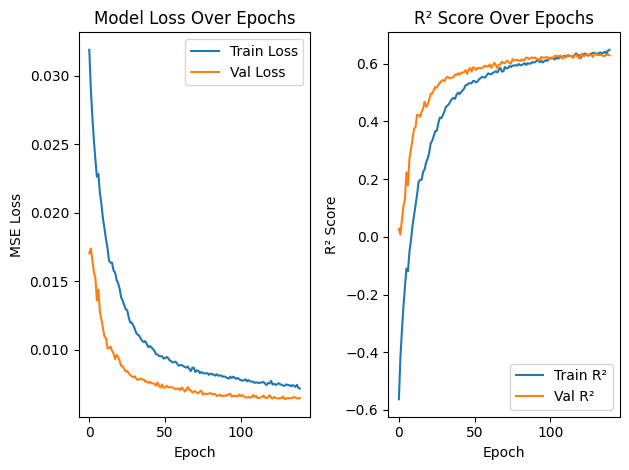

In [ ]:
# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# R²
plt.subplot(1, 2, 2)
plt.plot(history.history['r2_score'], label='Train R²')
plt.plot(history.history['val_r2_score'], label='Val R²')
plt.title('R² Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.legend()

plt.tight_layout()
plt.show()

Evaluate the model on test data

In [ ]:

test_loss, test_r2 = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test R² Score: {test_r2:.4f}")

Test Loss (MSE): 0.0050
Test R² Score: 0.4861


In [ ]:
# Predict on the test data
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = target_scaler.inverse_transform(y_pred)

# Calculate performance metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R-squared (R²): {r2:.4f}')

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Mean Squared Error (MSE): 0.2083
Root Mean Squared Error (RMSE): 0.4564
Mean Absolute Error (MAE): 0.3086
R-squared (R²): 0.5792


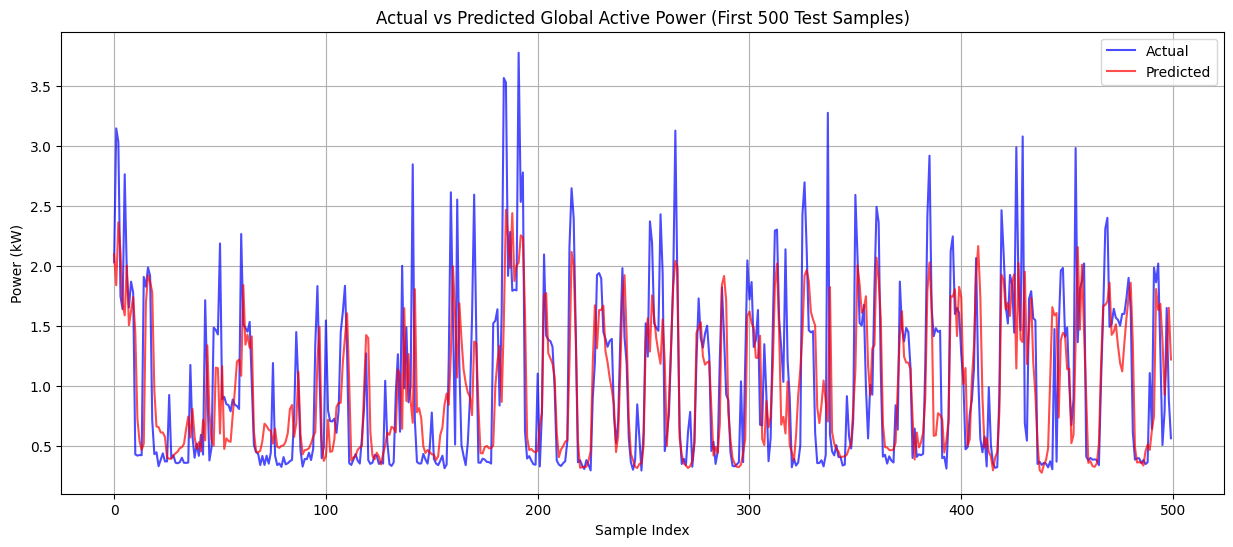

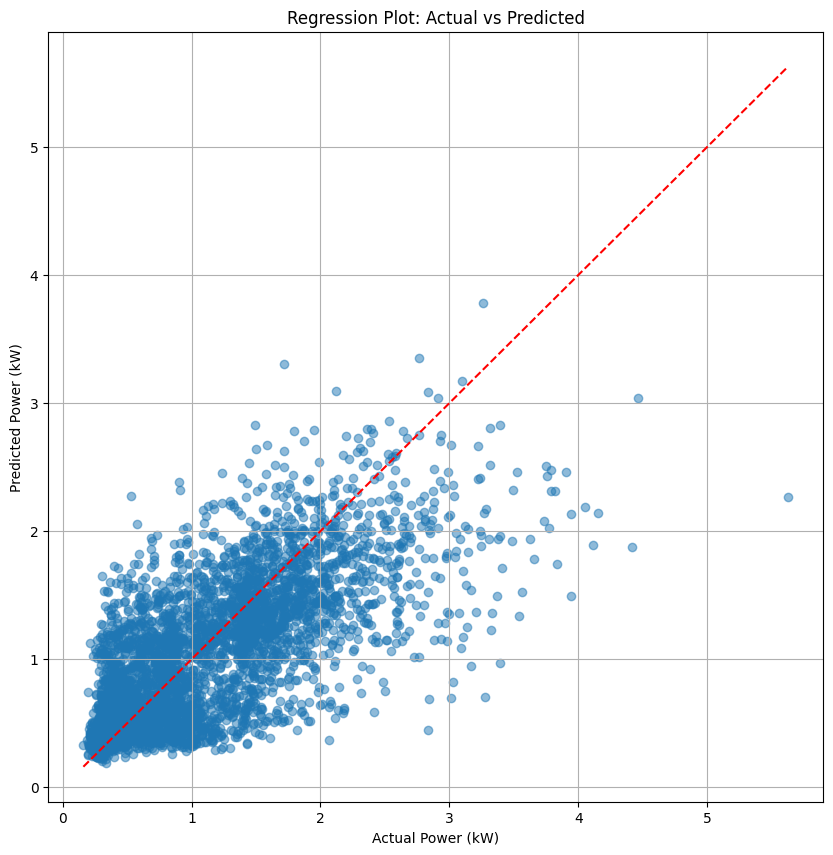

In [ ]:
# Visualize predictions vs actual values
plt.figure(figsize=(15, 6))
plt.plot(y_test_inv[:500], label='Actual', color='blue', alpha=0.7)
plt.plot(y_pred_inv[:500], label='Predicted', color='red', alpha=0.7)
plt.title('Actual vs Predicted Global Active Power (First 500 Test Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Power (kW)')
plt.legend()
plt.grid(True)
plt.show()

# Plot regression line
plt.figure(figsize=(10, 10))
plt.scatter(y_test_inv, y_pred_inv, alpha=0.5)
plt.plot([y_test_inv.min(), y_test_inv.max()], [y_test_inv.min(), y_test_inv.max()], 'r--')
plt.xlabel('Actual Power (kW)')
plt.ylabel('Predicted Power (kW)')
plt.title('Regression Plot: Actual vs Predicted')
plt.grid(True)
plt.show()

Error analysis

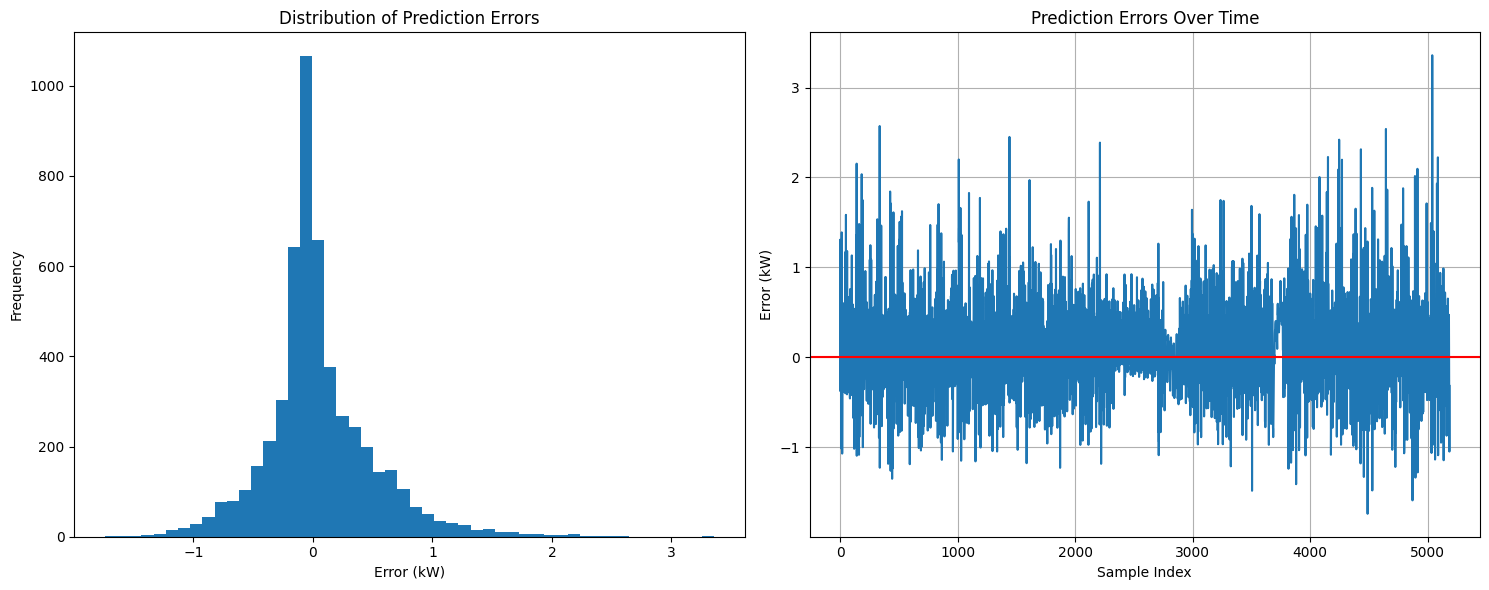

In [ ]:
errors = y_test_inv - y_pred_inv
plt.figure(figsize=(15, 6))

# Distribution of errors
plt.subplot(1, 2, 1)
plt.hist(errors, bins=50)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error (kW)')
plt.ylabel('Frequency')

# Errors over time
plt.subplot(1, 2, 2)
plt.plot(errors)
plt.title('Prediction Errors Over Time')
plt.xlabel('Sample Index')
plt.ylabel('Error (kW)')
plt.axhline(y=0, color='r', linestyle='-')
plt.grid(True)

plt.tight_layout()
plt.show()

Feature importance analysis
 * Analyze feature importance by zeroing out each feature in turn.

In [ ]:
def feature_importance_analysis(model, X_test, y_test, feature_names):

    baseline_loss, baseline_r2 = model.evaluate(X_test, y_test, verbose=0)

    # Store feature importance
    feature_importance = []

    # For each feature
    for i in range(X_test.shape[2]):
        # Create a copy of test data
        X_test_modified = X_test.copy()

        # Zero out the feature
        X_test_modified[:, :, i] = 0

        # Evaluate
        loss, r2 = model.evaluate(X_test_modified, y_test, verbose=0)

        # Calculate importance as increase in loss
        importance = loss - baseline_loss
        feature_importance.append(importance)

    # Normalize
    feature_importance = np.array(feature_importance)
    feature_importance = feature_importance / feature_importance.sum()

    return feature_importance

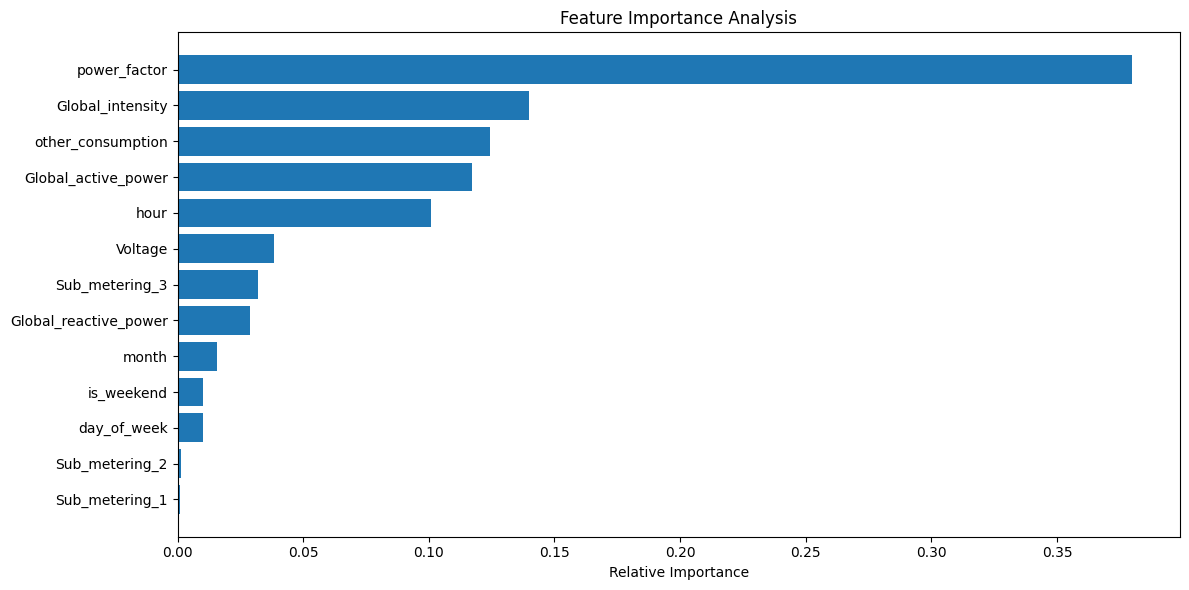

In [ ]:
# Calculate feature importance
feature_names = model_data.columns
feature_importance = feature_importance_analysis(model, X_test, y_test, feature_names)

# Plot feature importance
plt.figure(figsize=(12, 6))
indices = np.argsort(feature_importance)
plt.barh(range(len(indices)), feature_importance[indices])
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.title('Feature Importance Analysis')
plt.tight_layout()
plt.show()

Make predictions on new data (next 24 hours)

In [ ]:

def predict_next_n_hours(model, last_sequence, n_hours=24):
    """Predict the next n hours based on the last sequence."""
    predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(n_hours):
        # Reshape for prediction
        current_reshape = current_sequence.reshape(1, current_sequence.shape[0], current_sequence.shape[1])

        # Predict next hour
        next_hour_norm = model.predict(current_reshape)[0][0]
        predictions.append(next_hour_norm)

        # Update sequence (remove oldest, add newest prediction)
        # This is simplified as we're only updating the Global_active_power feature
        new_row = current_sequence[-1].copy()
        new_row[0] = next_hour_norm  # Update Global_active_power

        # Add prediction to sequence and remove the oldest entry
        current_sequence = np.vstack([current_sequence[1:], new_row])

    # Inverse transform to get actual power values
    predictions_array = np.array(predictions).reshape(-1, 1)
    return target_scaler.inverse_transform(predictions_array)

# Get the last sequence from the test data
last_sequence = X_test[-1]

# Predict next 24 hours
future_predictions = predict_next_n_hours(model, last_sequence, n_hours=24)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Plot the predictions

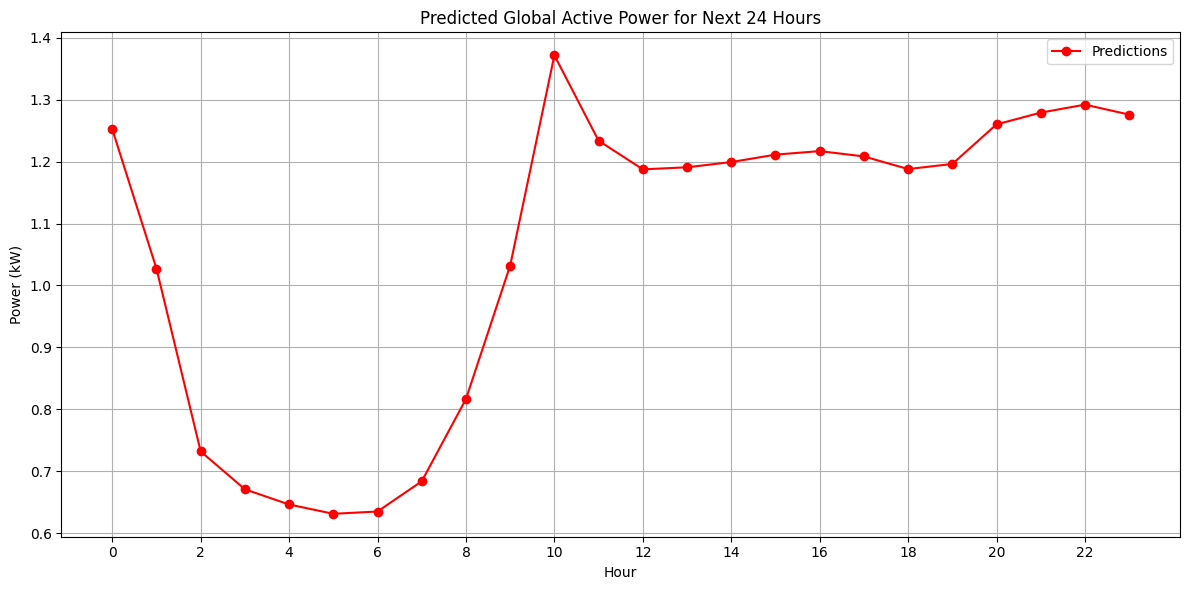

In [ ]:

plt.figure(figsize=(12, 6))
plt.plot(range(24), future_predictions, 'r-o', label='Predictions')
plt.title('Predicted Global Active Power for Next 24 Hours')
plt.xlabel('Hour')
plt.ylabel('Power (kW)')
plt.grid(True)
plt.legend()
plt.xticks(range(0, 24, 2))
plt.tight_layout()
plt.show()

# Results
* This project applies a deep learning approach using a Bidirectional LSTM-based Recurrent Neural Network (RNN) to forecast short-term household energy consumption with the UCI Household Power Consumption dataset.
* The workflow includes detailed preprocessing steps such as handling missing values, resampling to hourly intervals, time-based feature engineering, normalization, and sequence generation.
* The model was trained on multivariate time series data to predict future energy usage, achieving a final test RMSE of 0.4564 kW, MAE of 0.3086 kW, and an R² score of 0.5792 after inverse scaling—indicating strong predictive performance given the nature of the data.

* Despite the R² being below 0.6, the results are realistic and meaningful, as energy consumption data is inherently noisy and affected by unmeasured external factors (e.g., weather, human behavior).
* The training history shows no signs of overfitting (validation loss does not diverge from training loss), and no underfitting, as both losses decrease consistently and R² scores improve throughout training.
* These outcomes suggest that the model generalizes well to unseen data and captures significant temporal patterns, making it a practical solution for real-world energy forecasting.
